In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from tabulate import tabulate

from playsound import playsound
playsound('ta_da_short.mp3')

import importlib

import SIDMlib

# Some comments

## The units
I will use the following units:
1. distances in kpc
2. masses in M_sun
3. time in 10^9 years (GYR)
4. in these units 1pc/MYr = 1kpc/GyR = 0.977 km/s ~ 1km/s

## NFW potential theory

Important integrals for NFW are:

$\frac{1}{R} \int 4 \pi r^2 \frac{\rho}{(r/r_h)(1+r/r_h)^2} dr  = \frac{4\pi \rho r_h}{R} \int \frac{r dr}{(1+r/r_h)^2} = 4\pi r_h^3 \int \frac{x dx}{(1+x)^2} = \frac{1}{R} 4\pi r_h^3\rho \left[\ln(1+x) + \frac{1}{1+x}+C\right]_{x=0}^{x=R/r_h}  = \frac{1}{R} 4\pi r_h^3\rho \left[\ln(1+R/r_h) + \frac{1}{1+R/r_h}-1\right]$

$ \int 4\pi r \frac{\rho}{(r/r_h)(1+r/r_h)^2} dr = 4\pi \rho r_h \int  \frac{dr}{(1+r/r_h)^2} = 4\pi \rho r_h^2  \int  \frac{dx}{(1+x)^2} = \left. -\frac{4\pi \rho r_h^2}{1+x} \right|_{x=R/r_h}^{x=\infty} = \frac{4\pi \rho r_h^2}{1+R/r_h}$

So the full potential should be:

$ \Phi = 4\pi G r_h^2\rho \left[ \frac{r_h}{R} \left(\ln(1+R/r_h) + \frac{1}{1+R/r_h}-1\right) + \frac{1}{1+R/r_h} \right]$


In [33]:
def pot_NFW(R, G=4.5e-6 , rh=19.6, rho0=8.54e6):
    
    Rn = R/rh
    return -4*np.pi*G*rh**2*rho0*( (np.log(1.0+Rn)+1.0/(1.0+Rn)-1.0)/Rn + 1.0/(1.0+Rn) )

## Usefull Tables

In [7]:
## Make a table for mem_use, time and slice calculations


NNs = np.sort(np.concatenate((64*np.power(2,np.arange(8)),3*32*np.power(2,np.arange(7)))))

slices = SIDMlib.det_slices(NNs,memory=4)
runtimes = SIDMlib.time_estimate(NNs)
runtimesf = []
for time in runtimes:
    if time > 3600:
        runtimesf.append(f"{time/3600:.1f}hr")
    elif time > 60:
        runtimesf.append(f"{time/60:.1f}min")
    else:
        runtimesf.append(f"{time:.1f}sec")

A = np.concatenate(([['NN','slices','mem [GB]','runtime']],np.array([NNs,slices,SIDMlib.predict_mem(NNs,slices),runtimesf]).T)).T
print(tabulate(A, tablefmt='fancy_grid',floatfmt=".2f"))

╒══════════╤══════════╤═════════════╤════════╤══════════╤════════╤════════╤═════════╤════════╤════════╤═════════╤═════════╤═══════╤═══════╤════════╤════════╕
│ NN       │ 64       │ 96          │ 128    │ 192      │ 256    │ 384    │ 512     │ 768    │ 1024   │ 1536    │ 2048    │ 3072  │ 4096  │ 6144   │ 8192   │
├──────────┼──────────┼─────────────┼────────┼──────────┼────────┼────────┼─────────┼────────┼────────┼─────────┼─────────┼───────┼───────┼────────┼────────┤
│ slices   │ 1        │ 1           │ 1      │ 1        │ 1      │ 1      │ 2       │ 8      │ 16     │ 64      │ 128     │ 512   │ 1024  │ 4096   │ 8192   │
├──────────┼──────────┼─────────────┼────────┼──────────┼────────┼────────┼─────────┼────────┼────────┼─────────┼─────────┼───────┼───────┼────────┼────────┤
│ mem [GB] │ 0.015625 │ 0.052734375 │ 0.125  │ 0.421875 │ 1.0    │ 3.375  │ 4.0     │ 3.375  │ 4.0    │ 3.375   │ 4.0     │ 3.375 │ 4.0   │ 3.375  │ 4.0    │
├──────────┼──────────┼─────────────┼────────┼──────

In [97]:
props = SIDMlib.generate_props(nside=512, boundary=160.0)

In [108]:
importlib.reload(SIDMlib)
SIDMlib.chunked_prepare_gal('test_v1.h5', props, debug=True, with_dm=True, with_bar=False, is_complex=True, spherical=True)
SIDMlib.chunked_get_potential('test_v1.h5', props, debug=True, workers=4)    

Creating density profile [test_v1.h5]:   0%|          | 0/2 [00:00<?, ?it/s]

Computing Potential [test_v1.h5]:   0%|          | 0/10 [00:00<?, ?it/s]

In [109]:
index = 256
index_norm = 256+128
plane_x = np.real(SIDMlib.get_plane('test_v1.h5', index, axis=0))
xx,yy = np.meshgrid(props['xs'],props['xs'])
dz = props['xs'][index]

R = np.sqrt(xx**2+yy**2+dz**2)

/tmp/ipykernel_120954/2018811754.py:23: RuntimeWarning: invalid value encountered in divide
  plt.plot(R[index,index:],(plane_x[index,index:]-plane_x[index,index_norm])/(pot_NFW(R[index,index:])-pot_NFW(R[index,index_norm])),label='Ratio: FFT/theory')


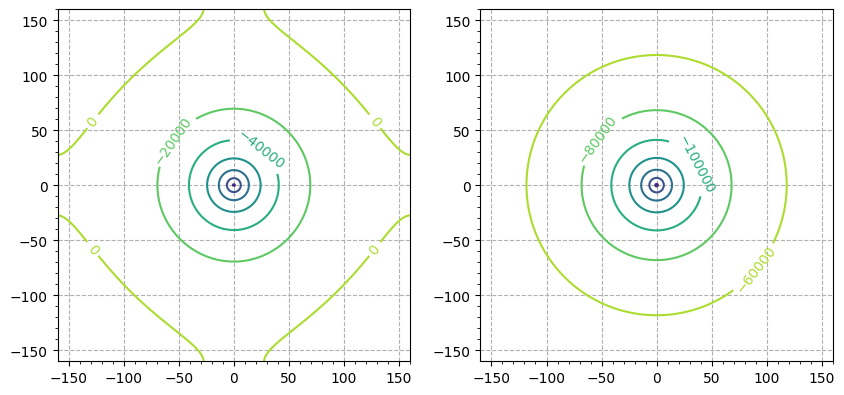

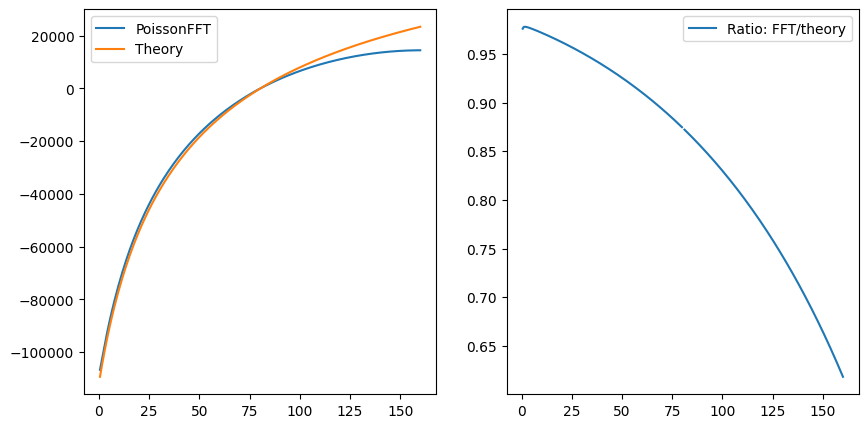

In [110]:
plt.figure(figsize=(10,5))

ax = plt.subplot(121,aspect='equal')
CS = plt.contour(xx,yy,plane_x)
ax.clabel(CS, inline=True, fontsize=10)
ax.grid(linestyle='--')
ax.minorticks_on()

ax = plt.subplot(122,aspect='equal')
CS = plt.contour(xx,yy,pot_NFW(R))
ax.clabel(CS, inline=True, fontsize=10)
ax.grid(linestyle='--')
ax.minorticks_on()
plt.plot()

plt.figure(figsize=(10,5))
ax = plt.subplot(121)
plt.plot(R[index,index:],plane_x[index,index:]-plane_x[index,index_norm],label='PoissonFFT')
plt.plot(R[index,index:],pot_NFW(R[index,index:])-pot_NFW(R[index,index_norm]),label='Theory')
plt.legend()

ax = plt.subplot(122)
plt.plot(R[index,index:],(plane_x[index,index:]-plane_x[index,index_norm])/(pot_NFW(R[index,index:])-pot_NFW(R[index,index_norm])),label='Ratio: FFT/theory')
plt.legend()
plt.show()

In [111]:
diffs = []
indices = range(256,300,2)

for index in indices:
    #index = 258
    plane_x = np.real(SIDMlib.get_plane('test_v1.h5', index, axis=0))
    xx,yy = np.meshgrid(props['xs'],props['xs'])
    dz = props['xs'][index]

    R = np.sqrt(xx**2+yy**2+dz**2)

    diff = (plane_x[index,index]-pot_NFW(R[index,index]))
    diffs.append(diff)

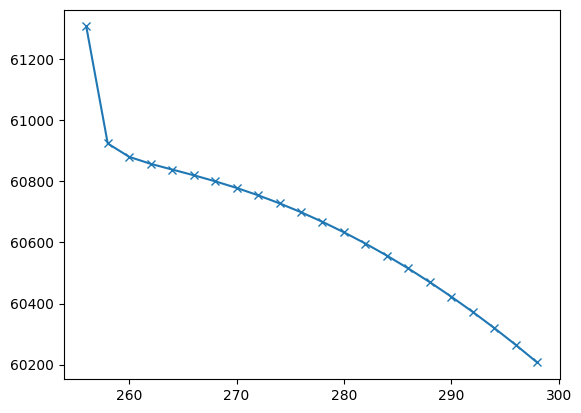

In [112]:
plt.plot(indices,diffs,'x-')

## Fixing stuff

Using the PoissonFFT technique we can solve the potential everywhere inside the volume up to a constant:

$\mathrm{PoissonFFT} \rightarrow \Phi(r) + C$

However, we can only do this up to a certain distance $r < R$.

As a result, we cannot determine the $C$ such that the following condition is true:

$\Phi(r \to \infty) = 0$.

This means that we cannot use the potential to determine the typical (or escape) velocity at a given radius.

What happens if we assume that only a spherical NFW profile is present?

For one thing, we know that in a spherically symmetric distribution, the potential is given by:

$$ \Phi(R) = -G \left[\frac{1}{R} \int_0^{R} 4\pi r^2 dr \rho(r) + \int_R^\infty 4\pi r dr \rho(r) \right] $$

But we do know that the first integral is just the mass enclosed:

$$ \Phi(R) = -G \left[\frac{M(R)}{R}  + \int_R^\infty 4\pi r dr \rho(r) \right] $$

And we also know that by our boundary condition, the mass enclosed at $R=R_*$ is conserved (for smaller radii there might and in fact will be some mass shifting). Also, for $R > R_*$, the profile is the original NFW profile. As a result, $\Phi(R_*)$ is not going to change, though $\Phi(R < R_*)$ might change. But this means that we can calculate $C$, because we know $\Phi(R_*)_{FFT}+C$ and we also know $\Phi(R_*)_{NFW}$ from the initial condition: we can use the theory prediction. 


Just to repeat, to determine $C$ simply do:

$$\Phi(R_*)_{\mathrm{FFT}} + C = \Phi(R_*)_{\mathrm{NFW, theory}}$$

with a boundary far away from $R_*$.

## What about Baryons?

Technically we can calculate the potential prediction also from the baryons...

### Away from the spherical symmetry...

The full expression actually reads:

$$\Phi(\vec{R}) = \sum_l \sum_m \frac{1}{2l+1} \left[r^{l} P^*_{lm}(r) + r^{-l-1} Q^*_{lm}(r)\right] Y_{lm}(\theta,\phi)$$

where:

$$P_{lm}(r) = \int d\Omega \int_r^\infty x^2 dx \rho(x,\theta,\phi)Y_{lm}(\theta,\phi) x^{-l-1} $$

$$Q_{lm}(r) = \int d\Omega \int_0^r x^2 dx \rho(x,\theta,\phi)Y_{lm}(\theta,\phi) x^l$$

So, we can try the first, $l=0$, term to get the familiar result:

$$\Phi(\vec{R}) =  \left[P^*_{00}(r) + r^{-1} Q^*_{00}(r)\right] Y_{00}(\theta,\phi)$$

$$P_{00}(r) = \int d\Omega \int x dx \rho(x,\theta,\phi)Y_{00}(\theta,\phi) = \int_r^\infty x dx \rho(\vec{x})$$

$$Q_{00}(r) = \int d\Omega \int x^2 dx \rho(x,\theta,\phi)Y_{00}(\theta,\phi) = \int_0^r x^2 dx \rho(\vec{x})$$

The next term contributes, where $|N_{1,1}|^2 = \frac{3}{8\pi}, |N_{1,-1}|^2 = \frac{3}{8\pi}, |N_{1,0}|^2 = \frac{3}{4\pi}$:

$$\Phi(\vec{R}) = \sum_m \frac{1}{3} \left[r P^*_{1m}(r) + r^{-2} Q^*_{1m}(r)\right] N_{1m} e^{im\phi} P_{1m}(\theta)$$

$$P_{1m}(r) = \int d\Omega \int_r^\infty dx \rho(x,\theta,\phi) N_{1m} e^{im\phi} P_{1m}(\theta) $$

$$Q_{1m}(r) = \int d\Omega \int_0^r x^3 dx \rho(x,\theta,\phi) N_{1m} e^{im\phi} P_{1m}(\theta)$$

where I will use:

$P_{1,0} = +\cos(\theta)$

$P_{1,\pm 1} = \mp\sin(\theta)$

And so for $m=0$:

$$\Phi(\vec{R}) = \frac{1}{4\pi} \left[r P^*_{10}(r) + r^{-2} Q^*_{10}(r)\right]  \cos(\theta)$$

$$P^*_{10}(r) = \int d\Omega \int_r^\infty dx \rho(\vec{x}) \cos(\theta) $$

$$Q^*_{10}(r) = \int d\Omega \int_0^r x^3 dx \rho(\vec{x}) \cos(\theta)$$

For $m=1$:

$$\Phi(\vec{R}) = \frac{1}{8\pi} \left[r P^*_{1,1}(r) + r^{-2} Q^*_{1,1}(r)\right]  e^{i\phi} \sin(\theta)$$

$$P^*_{1,1}(r) = \int d\Omega \int_r^\infty dx \rho(\vec{x})  e^{-i\phi} \sin(\theta) $$

$$Q^*_{1,1}(r) = \int d\Omega \int_0^r x^3 dx \rho(\vec{x})  e^{-i\phi} \sin(\theta)$$

For $m=-1$:

$$\Phi(\vec{R}) = \frac{1}{8\pi} \left[r P^*_{1,-1}(r) + r^{-2} Q^*_{1,-1}(r)\right]  e^{-i\phi} \sin(\theta)$$

$$P^*_{1,-1}(r) = \int d\Omega \int_r^\infty dx \rho(\vec{x})  e^{i\phi} \sin(\theta) $$

$$Q^*_{1,-1}(r) = \int d\Omega \int_0^r x^3 dx \rho(\vec{x})  e^{i\phi} \sin(\theta)$$

HOWEVER, THESE ARE ALL 0, BECAUSE OF THE REFLECTION SYMMETRY. WE NEED TO ACCESS L=2.

## Some analysis of $Y_{2,m}$

Stolen from: https://farside.ph.utexas.edu/teaching/jk1/Electromagnetism/node29.html

also see: https://en.wikipedia.org/wiki/Table_of_spherical_harmonics

$\displaystyle Y_{0,0}(\theta,\varphi)$	$\displaystyle = \left(\frac{1}{4\pi}\right)^{1/2}$

$\displaystyle Y_{1,-1}(\theta,\varphi)$	$\displaystyle = \left(\frac{3}{8\pi}\right)^{1/2}\sin\theta\,\,{\rm e}^{-{\rm i}\,\varphi},$

$\displaystyle Y_{1,0}(\theta,\varphi)$	$\displaystyle = \left(\frac{3}{4\pi}\right)^{1/2}\cos\theta,$

$\displaystyle Y_{1,+1}(\theta,\varphi)$	$\displaystyle =- \left(\frac{3}{8\pi}\right)^{1/2}\sin\theta\,\,{\rm e}^{+{\rm i}\,\varphi},$

$\displaystyle Y_{2,-2}(\theta,\varphi)$	$\displaystyle =\left(\frac{15}{32\pi}\right)^{1/2}\sin^2\theta\,{\rm e}^{-2\,{\rm i}\,\varphi} \to (x-iy)^2$

$\displaystyle Y_{2,-1}(\theta,\varphi)$	$\displaystyle =\left(\frac{15}{8\pi}\right)^{1/2}\sin\theta\,\cos\theta\,{\rm e}^{-{\rm i}\,\varphi} \to z(x-iy)$

$\displaystyle Y_{2,0}(\theta,\varphi)$	$\displaystyle =\left(\frac{5}{16\pi}\right)^{1/2}(3\,\cos^2\theta-1) \to (3z^2-r^2)$

$\displaystyle Y_{2,+1}(\theta,\varphi)$	$\displaystyle =-\left(\frac{15}{8\pi}\right)^{1/2}\sin\theta\,\cos\theta\,{\rm e}^{+{\rm i}\,\varphi} \to z(x+iy)$ 

$\displaystyle Y_{2,+2}(\theta,\varphi)$	$\displaystyle =\left(\frac{15}{32\pi}\right)^{1/2}\sin^2\theta\,{\rm e}^{+2\,{\rm i}\,\varphi} \to (x+iy)^2$

Where we can express this as:

$\cos(\theta) = z/r$

$e^{i\pm \phi} \sin(\theta) = (x\pm iy)/r$

$$\Phi(\vec{R}) = \sum_{l,m} \frac{1}{2l+1} \left[r^{l} P^*_{lm}(r)Y_{lm}(\theta,\phi) + r^{-l-1} Q^*_{lm}(r)Y_{lm}(\theta,\phi)\right] $$

$$\Phi(\vec{R}) = \sum_{l,|m|} \frac{1}{2l+1} \left[r^{l} \left\{P^*_{l,m}(r)Y_{l,m}+P^*_{l,-m}(r)Y_{l,-m}\right\} + r^{-l-1} \left\{Q^*_{l,m}(r)Y_{l,m}+Q^*_{l,-m}(r)Y_{l,-m}\right\}\right] $$

$$\Phi(\vec{R}) = \sum_{l,|m|} \frac{1}{2l+1} \left[r^{l}Y_{l} \left\{P^*_{l,m}(r)e^{im\phi}+P^*_{l,-m}(r)e^{-im\phi}\right\} + \cdots\right] $$

$$P^*_{l,m}(r) = \int d\Omega \int_r^\infty x^2 dx \rho(x,\theta,\phi)Y_{l}e^{-im\phi} x^{-l-1}  = I_{\cos} - i I_{\sin}$$
$$P^*_{l,-m}(r) = \int d\Omega \int_r^\infty x^2 dx \rho(x,\theta,\phi)Y_{l}e^{im\phi} x^{-l-1}  = I_{\cos} + i I_{\sin}$$



$$[\cos( m \phi)+i\sin( m \phi) ](I_{\cos} - iI_{\sin}) + [\cos( m \phi)-i\sin( m \phi) ](I_{\cos} + i I_{\sin})$$

$$2[\cos( m \phi)I_{\cos} + \sin( m \phi)I_{\sin} ]$$

$$e^{i\phi} = (x+iy) $$

$$e^{i 2\phi} = (x+iy)^2 = x^2+2ixy -y^2  $$

$$\cos(2\phi) = x^2-y^2$$
$$\sin(2\phi) = 2 x y $$

In [427]:
props_2 = SIDMlib.generate_props(nside=256, boundary=20.0)
SIDMlib.chunked_prepare_gal('test_v2.h5', props_2, debug=True, with_dm=True, with_bar=False, is_complex=True, spherical=True)
density = SIDMlib.get_fullarray('test_v2.h5')
xs = props_2['xs']
dx = props_2['dx']

Creating density profile [test_v2.h5]:   0%|          | 0/1 [00:00<?, ?it/s]

In [428]:
xx,yy,zz = np.meshgrid(xs,xs,xs,indexing='ij')
rsq = xx**2+yy**2+zz**2
r = np.sqrt(rsq)
R = 10.0
mask_in = (rsq < R**2)
mask_out = (rsq > R**2)

In [429]:
Q20_test = np.sum(np.real((3*zz**2-rsq)*density)[mask_in])*(dx**3)
P20_test = np.sum(np.real((3*zz**2-rsq)*density/r**5)[mask_out])*(dx**3)

In [430]:
P00_test = np.sum(np.real(density)[mask_in])*(dx**3)
Q00_test = np.sum(np.real(density/r)[mask_out])*(dx**3)

In [431]:
Q20 = []
P20 = []
Q00 = []
P00 = []
Rs = np.linspace(0,20,41)[1:]
for R in tqdm(Rs):
    mask_in = (rsq <= R**2)
    mask_out = (rsq >= R**2)
    
    Q20.append(np.sum(np.real((3*zz**2-rsq)*density)[mask_in])*(dx**3))
    P20.append(np.sum(np.real((3*zz**2-rsq)*density/r**5)[mask_out])*(dx**3))
    
    Q00.append(np.sum(np.real(density)[mask_in])*(dx**3))
    P00.append(np.sum(np.real(density/r)[mask_out])*(dx**3))

  0%|          | 0/40 [00:00<?, ?it/s]

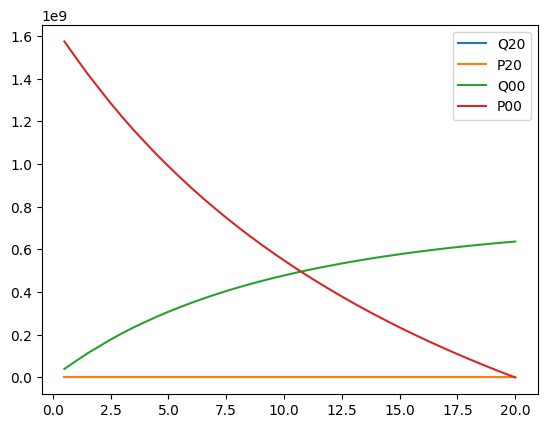

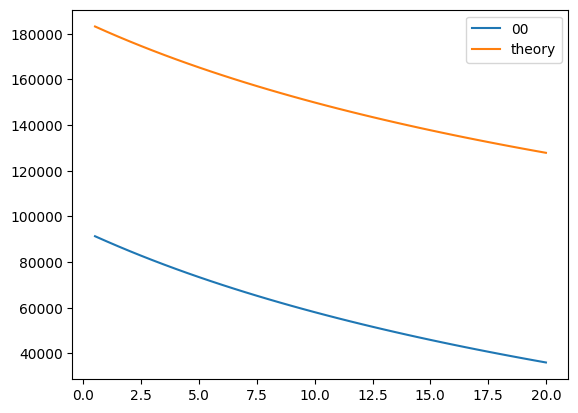

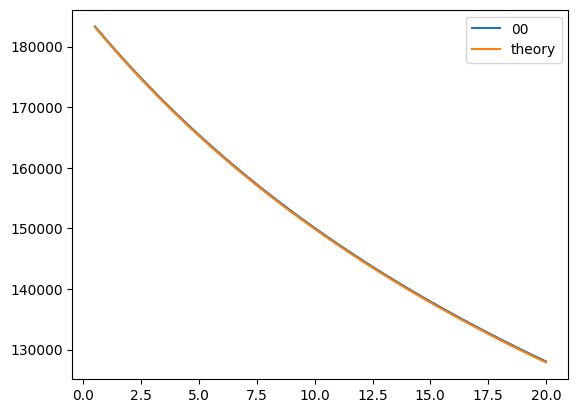

In [432]:
plt.plot(Rs,(5./(48.*np.pi))*np.array(Q20)/Rs**3,label='Q20')
plt.plot(Rs,(5./(48.*np.pi))*np.array(P20)*Rs**2,label='P20')
plt.plot(Rs,(1./(4.0*np.pi))*np.array(Q00)/Rs,label='Q00')
plt.plot(Rs,(1./(4.0*np.pi))*np.array(P00),label='P00')
plt.legend()
plt.show()

G_Newton = 4.5e-6

#plt.plot(Rs,(5./(48.*np.pi))*np.array(Q20)/Rs**3+(5./(48.*np.pi))*np.array(P20)*Rs**2,label='20')
plt.plot(Rs,4*np.pi*G_Newton*((1./(4.0*np.pi))*np.array(Q00)/Rs+(1./(4.0*np.pi))*np.array(P00)),label='00')
plt.plot(Rs,-pot_NFW(Rs),label='theory')
plt.legend()
plt.show()


plt.plot(Rs,4*np.pi*G_Newton*((1./(4.0*np.pi))*np.array(Q00)/Rs+(1./(4.0*np.pi))*np.array(P00))+92000,label='00')
plt.plot(Rs,-pot_NFW(Rs),label='theory')
plt.legend()
plt.show()

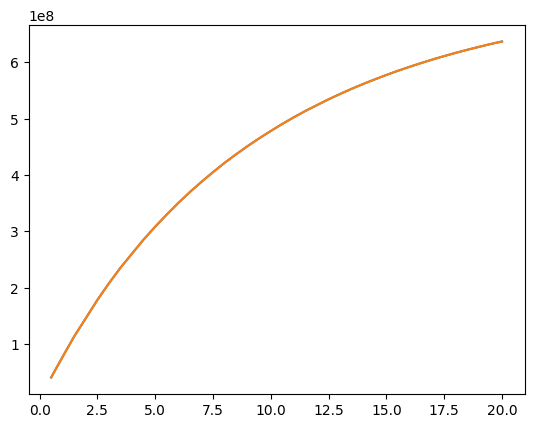

In [433]:
plt.plot(Rs,(1./(4.0*np.pi))*np.array(Q00)/Rs-1.0*(5./(48.*np.pi))*np.array(Q20)/Rs**3)
plt.plot(Rs,(1./(4.0*np.pi))*np.array(Q00)/Rs+2.0*(5./(48.*np.pi))*np.array(Q20)/Rs**3)


# The New Plan!

Since we maintain the cylindrical symmetry as well as the reflection symmetry we can:

1) Cylindrical symmetry implies we only use Y_{l,m=0} terms!
2) Reflection symmetry in z means we only need to keep z > 0 part of the volume
3) If we can figure out the integrals well, we really only need to keep the x=0,y>0,z>0 plane.

Advantages:

1) This would lead to a huge reduction of data we need to keep.
2) It also does not have problems with the boundary effect

In [434]:
myslice = np.real(density[128,128:,128:])

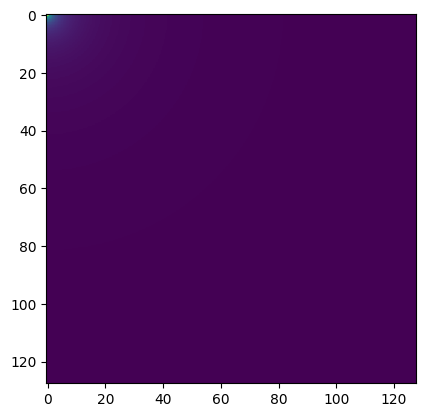

In [435]:
plt.imshow(myslice)

In [436]:
rr = np.sqrt(xx[128,128:,128:]**2+yy[128,128:,128:]**2)
ZZ = zz[128,128:,128:]
Rsq = rr**2+ZZ**2
R = np.sqrt(Rsq)

In [437]:
mask_in =  ( R <= 10.0 )
mask_out = ( R >= 10.0 )

In [438]:
mass1 = 2.0*np.sum(myslice*(2.0*np.pi*rr)*(dx**2))
mass2 = np.real(np.sum(density)*(dx**3))
mass1/mass2

1.000343181170925

In [439]:
Q20_test1 = 2*np.sum(np.real(2.0*np.pi*rr*(3*ZZ**2-Rsq)*myslice)[mask_in])*(dx**2)
P20_test1 = 2*np.sum(np.real(2.0*np.pi*rr*(3*ZZ**2-Rsq)*myslice/R**5)[mask_out])*(dx**2)

In [440]:
P00_test1 = 2*np.sum(np.real(2.0*np.pi*rr*myslice)[mask_in])*(dx**2)
Q00_test1 = 2*np.sum(np.real(2.0*np.pi*rr*myslice/R)[mask_out])*(dx**2)

In [441]:
P00_test1/P00_test

1.0033268631271295

In [442]:
Q00_test1/Q00_test

0.9981162889837514

In [443]:
print(P20_test1)
print(P20_test)

27256.378978561122
3.1475306335497657e-09


In [444]:
print(Q20_test1)
print(Q20_test)

-134970415.3187226
-7.727043143285683e-05
